<a href="https://www.kaggle.com/code/hanigaouaou/netflix-content-clustering?scriptVersionId=226196519" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## This mini-project will focus on processing and replacing missing values in a dataset. 
- The dataset chosen or generated must have a sufficient number of missing values to contribute to the main objective of this project.
- Each part in the project must be accompanied by a clear, valid, and detailed explanation, along with the corresponding code blocks.
- Respect exactly the same number of cells. Your marks will be strongly infuenced by the respect of this structure.

# 1. Defining project objectives and choosing a dataset:

## 1.1. Dataset Selection
I have chosen the **Netflix Movies and TV Shows** dataset from Kaggle.

## 1.2. Justification
This dataset is particularly suitable for our missing values analysis project because:
- It contains a significant number of missing values in multiple columns (director, cast, country, date_added, rating, duration)
- It represents real-world data from the entertainment industry
- It includes both categorical and numerical variables
- The data structure is well-organized with clear column definitions
- The nature of entertainment content makes it ideal for ***clustering analysis***


## 1.3. Objectives
1. Analyze patterns and distribution of missing values
2. Implement different imputation techniques based on data types
3. Develop a ***clustering model*** to categorize Netflix content based on features like:
   - Release year and duration
   - Genre combinations
   - Rating patterns
4. Evaluate how different missing value treatments affect clustering results
5. Determine the most effective imputation method for optimal cluster quality


## 1.4. Working Plan
1. Initial data exploration and missing value assessment
2. Pattern analysis of missing values
3. Development of appropriate imputation strategies
4. Feature preparation for clustering:
   - Handle categorical variables
   - Scale numerical features
   - Engineer relevant features
5. Clustering analysis:
   - Determine optimal number of clusters
   - Apply ***K-means clustering***
   - Evaluate cluster quality using ***silhouette analysis***
6. Compare clustering results across different imputation methods
7. Final validation and conclusions

***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("/kaggle/input/netflix-shows/netflix_titles.csv") # Getting the DataFrame from a csv file

# Display basic information
print("Dataset Overview:")
print("-" * 50)
print("\nDataset Shape:", df.shape)
print("\nColumns in the dataset:")
print(*df.columns.tolist(), sep=' |')
print("\nData Summary:")
df.info()
print("\nA Look into the dataset:")
df.tail(5)


Dataset Overview:
--------------------------------------------------

Dataset Shape: (8807, 12)

Columns in the dataset:
show_id |type |title |director |cast |country |date_added |release_year |rating |duration |listed_in |description

Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB

A

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."
8806,s8807,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,"March 2, 2019",2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...


# 2. Clean your data: 
- Evaluate the quality of data.
- Identify relevant features.
- Missing values or any additional operations ? (use different missing appraoches to tackle the missing values issue, create different data variants for a later comparison).   
- statistics, check data types, conversions and more ?
- Divide data into two parts one for experiments, another portion for validation (explain the logic of your splitting).

1.DATA QUALITY:
--------------------------------------------------
1.1. COMPLETENESS CHECK:

            Missing Values  Percent Missing
director              2634        29.908028
cast                   825         9.367549
country                831         9.435676
date_added              10         0.113546
rating                   4         0.045418
duration                 3         0.034064

Visualized:


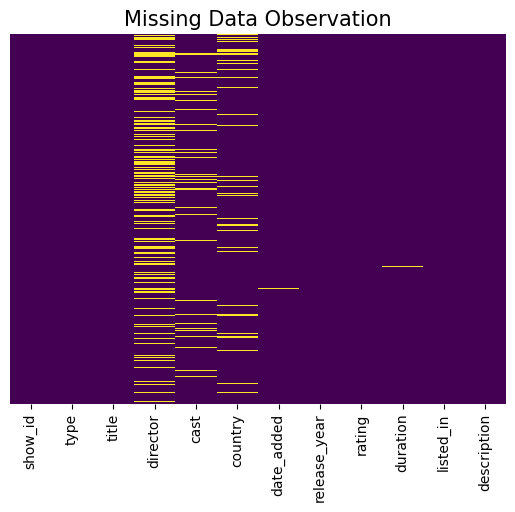


1.2. UNIQUENESS CHECK:

Total duplicate rows: 0
Percentage of duplicates: 0.00%

2. FEATURE RELEVANCE ANALYSIS:
The relevance score is given according to its importance in content clustering
--------------------------------------------------
Feature         Relevance  Rationale
type            High       Key differentiator between content categories.
release_year    High       Important for temporal clustering.
rating          High       Indicates target audience segments.
duration        High       Important for content length patterns.
listed_in       High       Contains genre information.
director        Medium     May influence content style.
cast            Medium     May influence content popularity.
country         Medium     Regional content patterns.
description     Low        Text data; requires preprocessing.
date_added      Low        Less relevant for content clustering.

After the analysis we can ommit the columns: "description" and "date_added"

=> Reduced dataset struc

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 1. Quality Evaluation:
print("1.DATA QUALITY:")
print("-" * 50)

print("1.1. COMPLETENESS CHECK:\n")

# Completeness Check (Missing Values)
missing_values = df.isnull().sum()[df.isnull().sum() > 0]
missing_percent = (missing_values / len(df)) * 100

# Combine missing count and percentage into a DataFrame
missing_data = pd.DataFrame({
    "Missing Values": missing_values,
    "Percent Missing": missing_percent
})

# Filter only features with missing values
missing_data = missing_data[missing_data["Missing Values"] > 0]
print(missing_data)
# A heatmap visualization for the missing values:
print("\nVisualized:")
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis');
plt.title("Missing Data Observation", fontsize = 15)
plt.show()

print("\n1.2. UNIQUENESS CHECK:\n")

duplicates = df.duplicated().sum()
print(f"Total duplicate rows: {duplicates}")
print(f"Percentage of duplicates: {(duplicates/len(df))*100:.2f}%")

# 2. Identify relevant features:
print("\n2. FEATURE RELEVANCE ANALYSIS:")
print("The relevance score is given according to its importance in content clustering")
print("-" * 50)
data = [
    ["Feature", "Relevance", "Rationale"],
    ["type", "High", "Key differentiator between content categories."],
    ["release_year", "High", "Important for temporal clustering."],
    ["rating", "High", "Indicates target audience segments."],
    ["duration", "High", "Important for content length patterns."],
    ["listed_in", "High", "Contains genre information."],
    ["director", "Medium", "May influence content style."],
    ["cast", "Medium", "May influence content popularity."],
    ["country", "Medium", "Regional content patterns."],
    ["description", "Low", "Text data; requires preprocessing."],
    ["date_added", "Low", "Less relevant for content clustering."]
]

for row in data:
    print("{:<15} {:<10} {}".format(*row))

print("\nAfter the analysis we can ommit the columns: \"description\" and \"date_added\"")
# Selected features based on relevance
selected_features = [
    "type", "release_year", "rating", "duration", "listed_in", 
    "director", "cast", "country"
]
# Create a reduced dataset
df_relevant = df[selected_features]
# Display the structure of the reduced dataset
print("\n=> Reduced dataset structure:\n",sep='\n')
print(df_relevant.info())

# from now our dataset is df_relevant

In [3]:
# Processing the duration column alone since the movies and tv shows each has a different number systems
# The following function will be used later in the 2nd dataset variant (filled dataset)
def process_duration(df):
    """
    Process and normalize the duration column for Netflix content, handling movies (minutes) 
    and TV shows (seasons) separately.
    
    Args:
        df (pd.DataFrame): DataFrame containing 'type' and 'duration' columns
    
    Returns:
        pd.DataFrame: DataFrame with processed and normalized duration values
    """
    # Ensure required columns are present
    required_columns = ['type', 'duration']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain columns: {required_columns}")

    # Create a copy to avoid modifying the original DataFrame
    df_relevant = df.copy()

    # Separate Movies and TV Shows
    movies = df_relevant[df_relevant["type"] == "Movie"].copy()
    tv_shows = df_relevant[df_relevant["type"] == "TV Show"].copy()

    # Process Movie durations
    try:
        movies["duration"] = movies["duration"].str.extract("(\d+)").astype(float)
    except Exception as e:
        print(f"Error processing movie durations: {e}")
        movies["duration"] = np.nan

    # Process TV Show durations
    try:
        tv_shows["duration"] = tv_shows["duration"].str.extract("(\d+)").astype(float)
    except Exception as e:
        print(f"Error processing TV show durations: {e}")
        tv_shows["duration"] = np.nan

    # Define and fit imputers
    imputer_median_movies = SimpleImputer(strategy="median")
    imputer_median_tv_shows = SimpleImputer(strategy="median")

    # Impute missing values
    movies.loc[:, "duration"] = imputer_median_movies.fit_transform(movies[["duration"]])
    tv_shows.loc[:, "duration"] = imputer_median_tv_shows.fit_transform(tv_shows[["duration"]])

    # Combine datasets and sort by original index
    df_processed = pd.concat([movies, tv_shows], axis=0)
    df_processed = df_processed.sort_index()

    return df_processed

In [4]:
# 4. Dealing with missing values:

# 4.1. Identify columns with missing values in the reduced dataset
missing_columns = df_relevant.columns[df_relevant.isnull().any()]
print(f"Columns with missing values: {missing_columns.tolist()}")
print("-" * 50)

# 4.2. Create data variants with different imputation strategies (dropped, mean_mode, custom)
dataset_variants = {}

# Variant 1:  ------------------------------------------------------------------------------------
# Drop rows with missing values

dataset_variants['dropped'] = df_relevant.dropna()

# Variant 2: -------------------------------------------------------------------------------------
# Fill missing values with the mode (for categorical) and median (for numerical)


# Dividing the missing_columns into categorical and numerical
categorical_features = ["rating", "director", "cast", "country"]
numerical_features = ["duration"]

df_processed = process_duration(df_relevant) # Defined earlier...

imputer_mode = SimpleImputer(strategy="most_frequent") # For categoricals
# A median imputer is already used in the process_duration function

# Apply imputer
df_mode_imputed = df_processed.copy()
df_mode_imputed[categorical_features] = imputer_mode.fit_transform(df_mode_imputed[categorical_features])
dataset_variants['mean_mode'] = df_mode_imputed


# Variant 3: -------------------------------------------------------------------------------------
# Fill missing values with a placeholder (e.g., "Unknown" or -1)

dataset_variants['custom'] = df_relevant.fillna({
    "rating": "Unknown",
    "director": "Unknown",
    "cast": "Unknown",
    "country": "Unknown",
    "duration": '-1'
})

# From now our datasets will be referred to as the dataset_variants
#-------------------------------------------------------------------------------------------------

# 3. Data Type Conversions, Transformations and Cleaning
# Since we have 3 different datasets, a function for each step is better to avoid repetition


def preprocess_dataset(df):
    df_processed = df.copy()
    
    # Convert release_year to numeric
    df_processed['release_year'] = df_processed['release_year'].astype("int")

    # Convert duration to numeric for 'dropped' and 'custom' dataset variants:
    if not pd.api.types.is_numeric_dtype(df_processed['duration']):
        df_processed['duration'] = df_processed['duration'].str.extract("(\d+)").astype(float)
    
    # Convert to categorical dtype for better memory usage and more versatility
    pd.Categorical(df, categories=["type", "rating", "listed_in", "director", "cast", "country"])
    
    return df_processed


# 4. Data Splitting: 
def split_dataset(df, test_size=0.2, random_state=42):
    """
    Split dataset into training and validation sets
    Stratify by 'type' to maintain distribution of movies/shows
    """
    train_df, val_df = train_test_split(
        df,
        test_size=test_size,
        random_state=random_state,
        stratify=df['type']
    )
    return train_df, val_df


# Process and split each variant
processed_variants = {}
split_variants = {}

for name, dataset in dataset_variants.items():
    # Process
    processed_variants[name] = preprocess_dataset(dataset)
    # Split
    train, val = split_dataset(processed_variants[name])
    split_variants[name] = {'train': train, 'val': val}

# 6. Print Summary Statistics for each variant
print("\n3. VARIANT COMPARISON:")
print("-" * 50)
for name, data in processed_variants.items():
    print(f"\nVariant: {name}")
    print(f"Missing values:")
    print(data[missing_columns].isnull().sum())
    print("\nBasic statistics:")
    print(data.describe().round(2))
    print("\nSplit sizes:")
    print(f"Training set: {len(split_variants[name]['train'])} records")
    print(f"Validation set: {len(split_variants[name]['val'])} records")
print(processed_variants["custom"]["duration"][processed_variants["custom"]["duration"].isnull()])
 

Columns with missing values: ['rating', 'duration', 'director', 'cast', 'country']
--------------------------------------------------

3. VARIANT COMPARISON:
--------------------------------------------------

Variant: dropped
Missing values:
rating      0
duration    0
director    0
cast        0
country     0
dtype: int64

Basic statistics:
       release_year  duration
count       5332.00   5332.00
mean        2012.74     99.92
std            9.63     30.46
min         1942.00      1.00
25%         2011.00     88.00
50%         2016.00    100.00
75%         2018.00    116.00
max         2021.00    253.00

Split sizes:
Training set: 4265 records
Validation set: 1067 records

Variant: mean_mode
Missing values:
rating      0
duration    0
director    0
cast        0
country     0
dtype: int64

Basic statistics:
       release_year  duration
count       8807.00   8807.00
mean        2014.18     69.86
std            8.82     50.81
min         1925.00      1.00
25%         2013.00      2.

# 3. Exploratory Data Analyses

## 3.1. Methodology and Approach:

### Data Understanding and Cleaning:

- Explore the dataset to identify patterns in missing values and understand the distribution of existing features.
- Treat missing values using appropriate imputation strategies based on the type of data.

### Feature Engineering:

Derive meaningful features to support clustering analysis:

- Release Year: To capture temporal patterns.
- Duration: Normalized to address discrepancies between TV show seasons and movie minutes.
- Genres: Processed into numerical or categorical formats to represent genre combinations.
- Ratings: Grouped into categories to capture audience segmentation.

### Relationships Analysis:

- Investigate correlations and dependencies between features:
  - Example: Analyze the relationship between release year and duration or genre trends over time.
- Visualize distributions and relationships to validate feature relevance.

### Data Preparation for Clustering:

- Standardize or normalize numerical features (e.g., duration, release year) to ensure fair weighting in clustering.
- Encode categorical features (e.g., genres and ratings) to ensure compatibility with clustering algorithms.

### Clustering and Evaluation:

- Apply clustering techniques (e.g., K-means, hierarchical clustering) using the engineered features.
- Evaluate clustering results using metrics like silhouette scores and interpret cluster characteristics.

### Analysis of Missing Value Treatments:

- Compare clustering outcomes based on different missing value imputation strategies to determine the most effective method.





In [5]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# ------------------------------------------------------------------------------------------------------------
# 5. Feature Engineering (necessary BEFORE creating variants)
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

def engineer_features(df):
    """
    Engineer features from the dataset with a focus on clustering-friendly transformations.
    Args:
        df (pd.DataFrame): Input DataFrame
    Returns:
        pd.DataFrame: DataFrame with engineered features optimized for clustering
    """
    df_engineered = df.copy()

    # 1. Temporal Features
    current_year = pd.Timestamp.now().year
    df_engineered['content_age'] = current_year - df_engineered['release_year']
    df_engineered['decade'] = (df_engineered['release_year'] // 10) * 10

    # Handle cases where 'release_year' might be missing or invalid
    df_engineered['content_age'].fillna(df_engineered['content_age'].median(), inplace=True)
    df_engineered['decade'].fillna(0, inplace=True)

    # 2. Genre Features
    df_engineered['primary_genre'] = df_engineered['listed_in'].str.split(',').str[0]
    df_engineered['multi_genre'] = df_engineered['listed_in'].str.contains(',').astype(int)
    df_engineered['genre_count'] = df_engineered['listed_in'].str.count(',') + 1

    # Create genre similarity features using TF-IDF
    tfidf = TfidfVectorizer(token_pattern=r'[^,\s]+')
    genre_tfidf = tfidf.fit_transform(df_engineered['listed_in'])
    genre_features = pd.DataFrame(
        genre_tfidf.toarray(),
        columns=[f'genre_feat_{i}' for i in range(genre_tfidf.shape[1])]
    )
    df_engineered = pd.concat([df_engineered.reset_index(drop=True), genre_features.reset_index(drop=True)], axis=1)

    # 3. Cast Features
    df_engineered['cast_size'] = df_engineered['cast'].str.count(',') + 1
    df_engineered['cast_diversity'] = df_engineered['cast'].apply(
        lambda x: len(set(x.split(','))) / max(len(x.split(',')), 1)
    )

    # 4. Country Features
    df_engineered['production_countries'] = df_engineered['country'].str.count(',') + 1
    df_engineered['is_international'] = (df_engineered['country'].str.count(',') > 0).astype(int)

    # 5. Rating Features
    rating_groups = {
        'Kids': ['TV-Y', 'TV-Y7', 'TV-Y7-FV', 'G'],
        'Teen': ['TV-PG', 'TV-G', 'PG', 'TV-14', 'PG-13'],
        'Adult': ['TV-MA', 'R', 'NC-17'],
        'Not Rated': ["NR", "UR", "Unknown"]
    }
    rating_mapping = {v: k for k, lst in rating_groups.items() for v in lst}
    df_engineered['rating_category'] = df_engineered['rating'].map(rating_mapping)

    # 6. Duration Features
    scaler = MinMaxScaler()
    df_engineered['duration_normalized'] = scaler.fit_transform(df_engineered[['duration']])
    df_engineered['log_duration'] = np.log1p(df_engineered['duration'].clip(lower=0))
    

    # 7. Encode Type and Rating
    le = LabelEncoder()
    df_engineered['type'] = le.fit_transform(df_engineered['type'])
    df_engineered['rating_score'] = le.fit_transform(df_engineered['rating_category'])
    
    # 8. Director popularity (frequency count in dataset)
    director_counts = df['director'].value_counts()
    df_engineered['director_popularity'] = df_engineered['director'].map(director_counts)
    df_engineered['director_popularity'] = scaler.fit_transform(df_engineered[['director_popularity']])
    
    # Director diversity (number of directors listed)
    df_engineered['director_count'] = df_engineered['director'].str.count(',') + 1

    return df_engineered


for name, dataset in processed_variants.items():
    # Apply feature engineering
    processed_variants[name] = engineer_features(dataset)
    print(f"Processed {name}: {processed_variants[name].shape}")

Processed dropped: (5332, 66)
Processed mean_mode: (8807, 66)
Processed custom: (8807, 66)



Analyzing dropped variant:


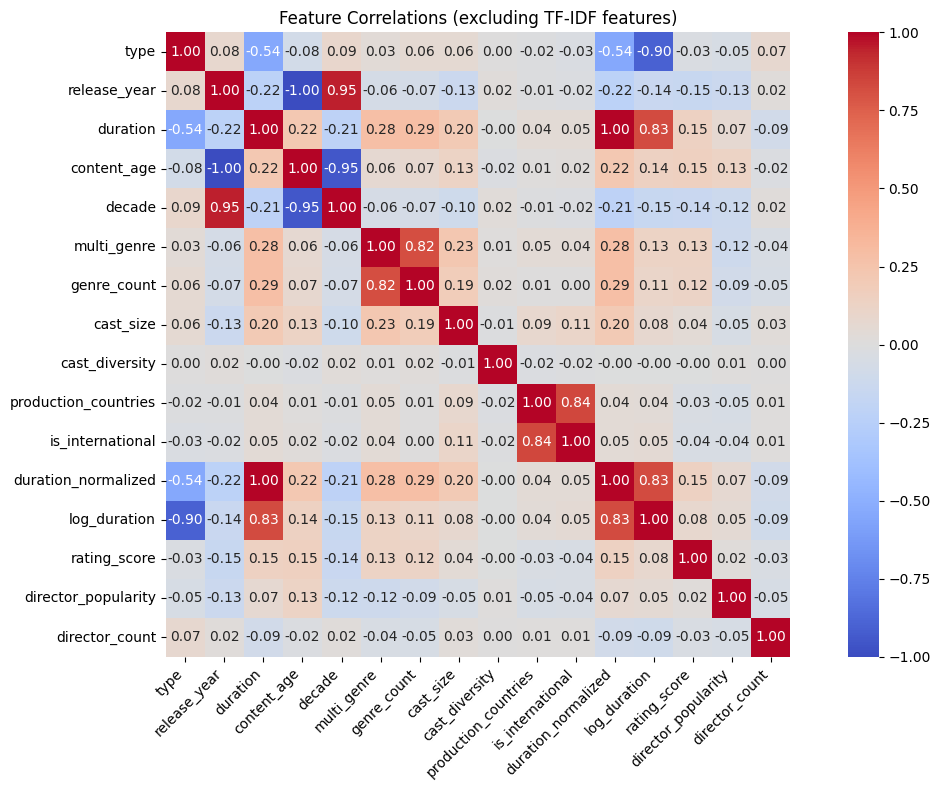


Analyzing mean_mode variant:


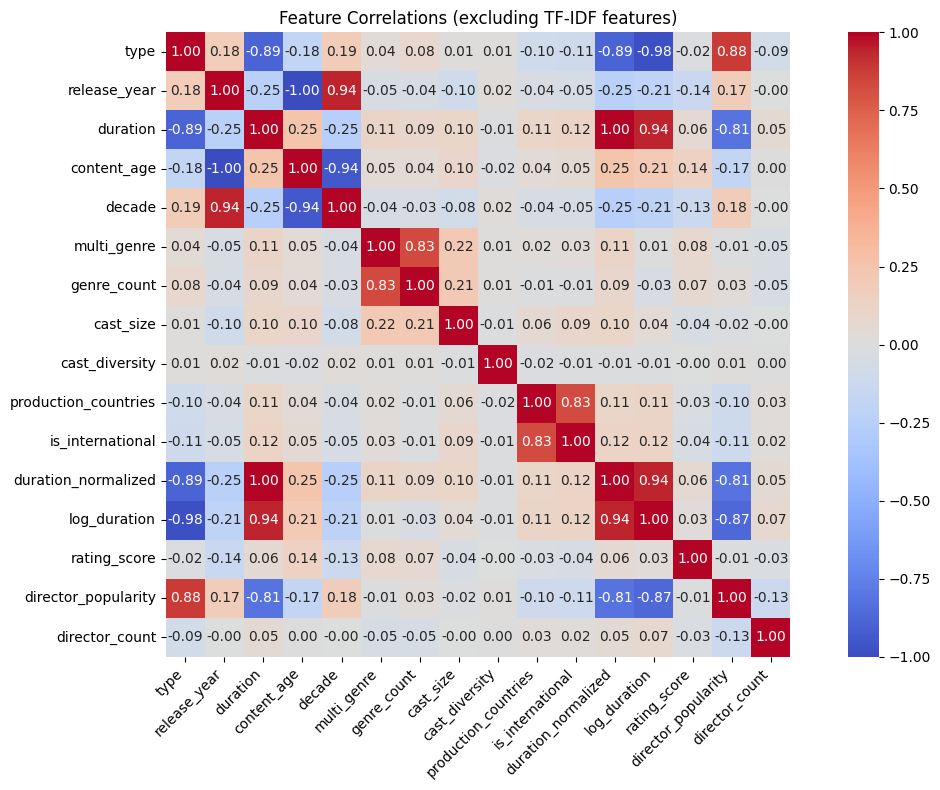


Analyzing custom variant:


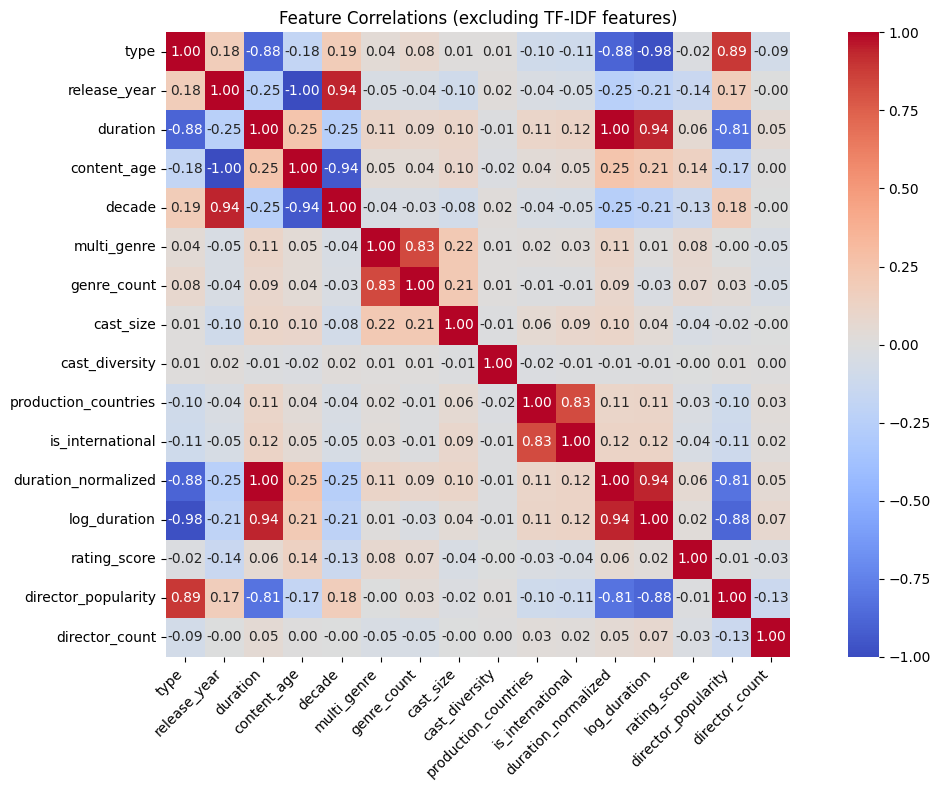

In [6]:

# Analyze feature correlations
def analyze_correlations(df):
    # Select numeric columns excluding TF-IDF features
    numeric_cols = [col for col in df.select_dtypes(include=['float64', 'int64']).columns 
                   if 'genre_feat' not in col]
    
    correlation_matrix = df[numeric_cols].corr()
    
    # Create correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, 
                cmap='coolwarm', 
                center=0, 
                annot=True,  
                fmt='.2f', 
                square=True)
    plt.title('Feature Correlations (excluding TF-IDF features)')
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    return correlation_matrix

for name, dataset in processed_variants.items():
    print(f"\nAnalyzing {name} variant:")
    
    # Analyze correlations
    corr_matrix = analyze_correlations(dataset)
    plt.show()


#### Key Findings:

The application of this feature engineering approach results in a dataset enriched with numerical and categorical features optimized for clustering. Key observations may include:

- Trends by Decade: Visualizing the distribution of decade could reveal surges or declines in content production.
- Genre Clusters: TF-IDF features allow for identifying content clusters with similar themes.
- Cast Dynamics: Analysis of cast_diversity could indicate whether a diverse cast correlates with specific content types or audience ratings.
- Global Reach: is_international and production_countries can demonstrate how international collaborations influence content characteristics.

#### Conclusion:
The feature engineering process creates a robust dataset ready for clustering. Key insights from the transformed features provide deeper understanding into temporal trends, genre diversity, and production patterns. This lays a solid foundation for advanced clustering and visualization techniques.

#### New Operations to Consider:

1. Feature Selection
2. Feature Aggregation


Processing dropped variant:


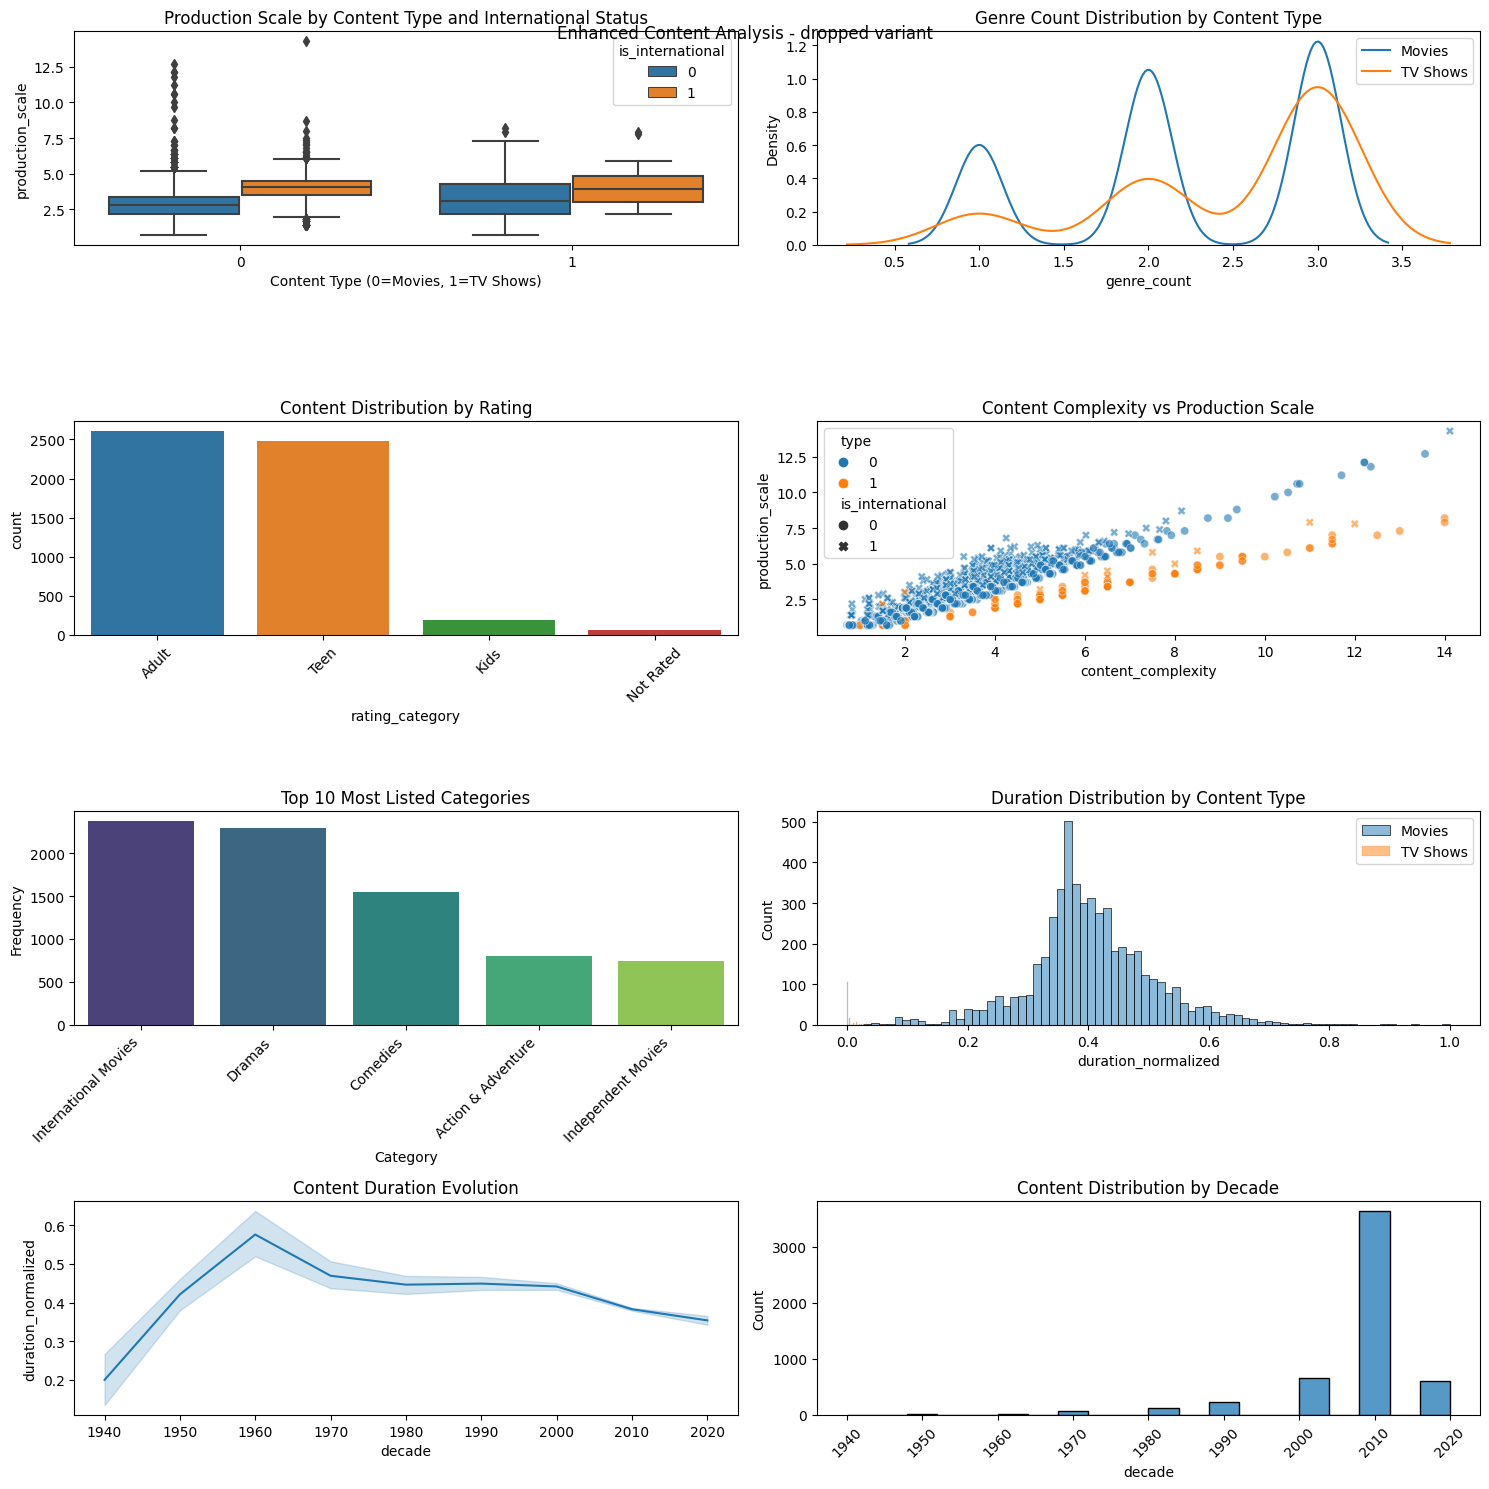


Summary Statistics by Content Type:

Movies:
       production_scale  content_complexity  genre_count  production_countries
count           5185.00             5185.00      5185.00               5185.00
mean               2.97                3.40         2.22                  1.29
std                1.25                1.25         0.77                  0.73
min                0.70                0.71         1.00                  1.00
25%                2.20                2.86         2.00                  1.00
50%                3.10                3.62         2.00                  1.00
75%                3.60                4.10         3.00                  1.00
max               14.30               14.12         3.00                  8.00

TV Shows:
       production_scale  content_complexity  genre_count  production_countries
count            147.00              147.00       147.00                147.00
mean               3.32                5.91         2.50                  

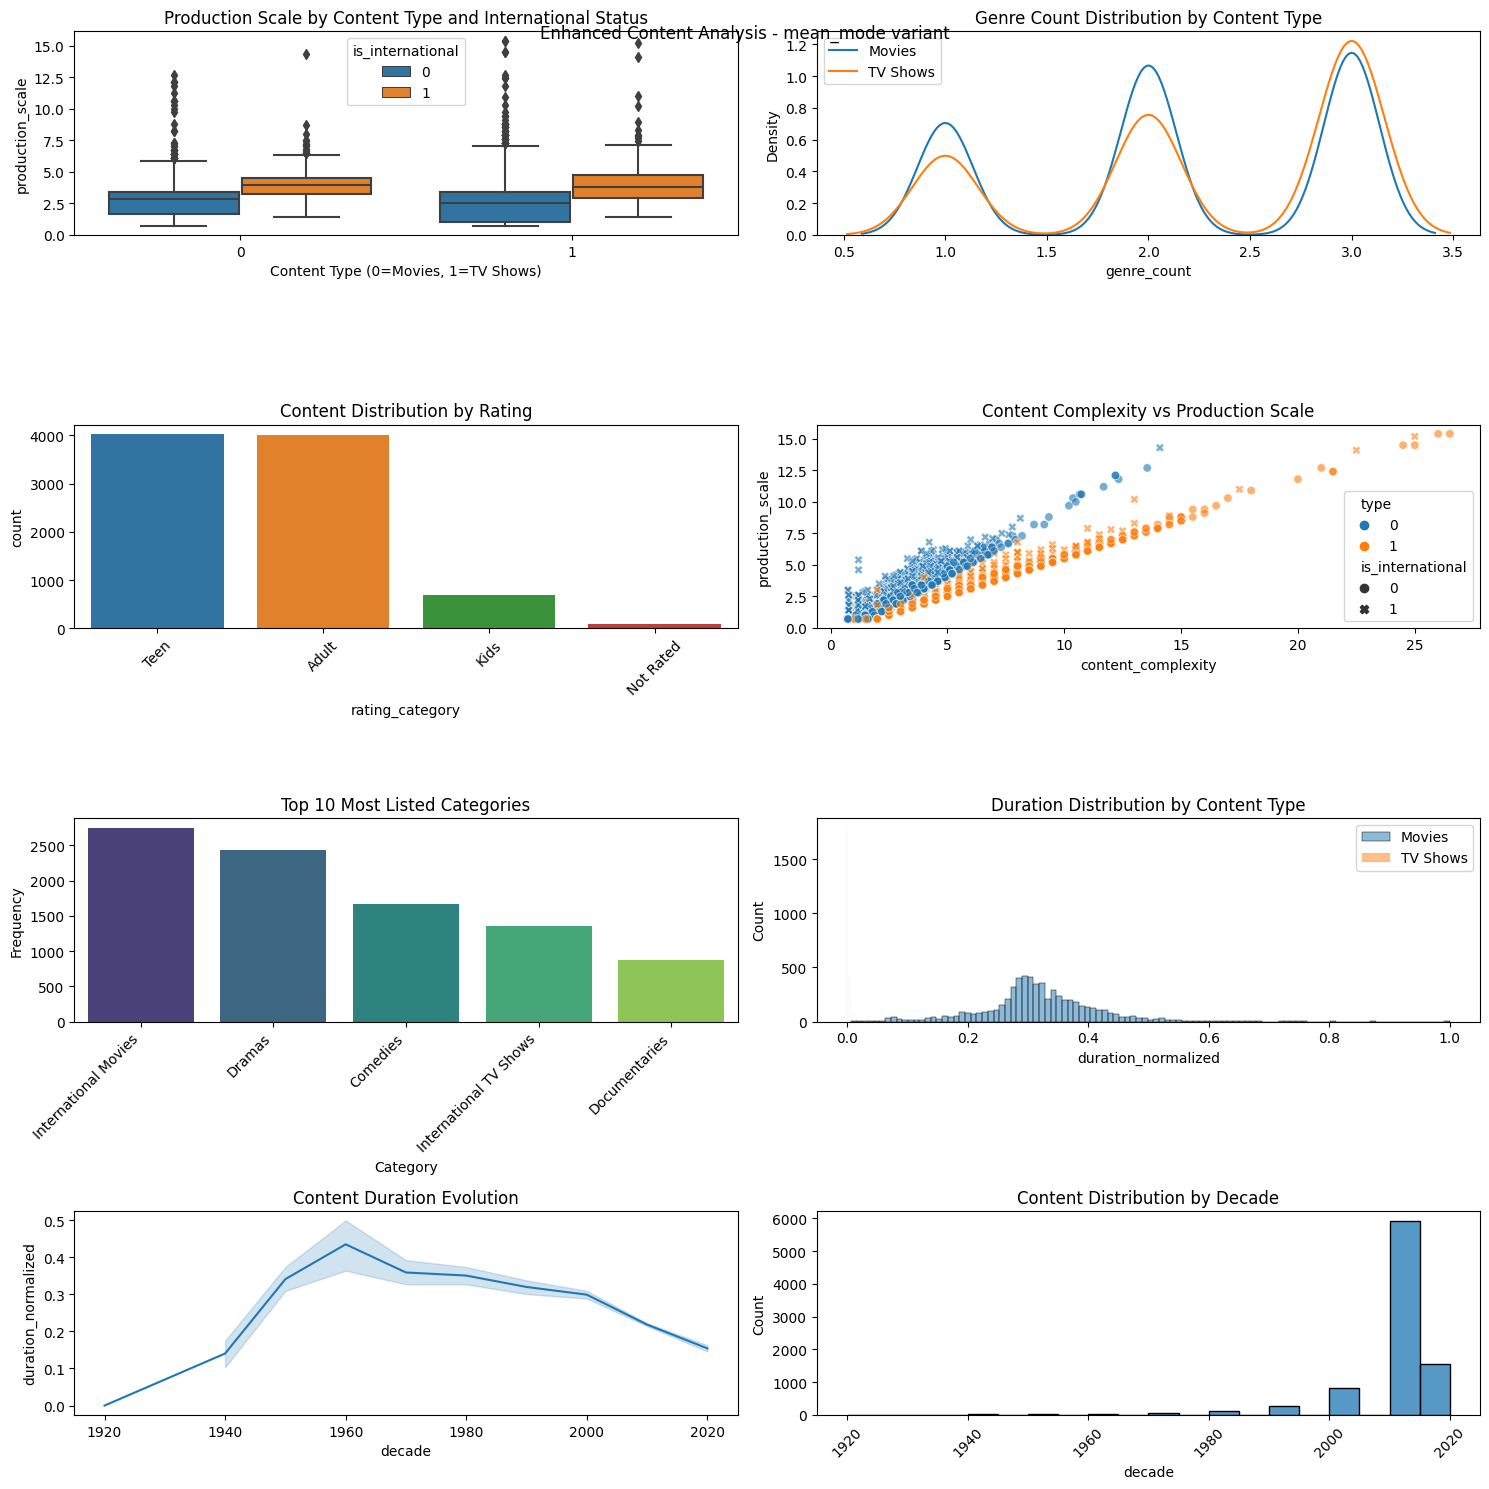


Summary Statistics by Content Type:

Movies:
       production_scale  content_complexity  genre_count  production_countries
count           6131.00             6131.00      6131.00               6131.00
mean               2.76                3.16         2.15                  1.28
std                1.34                1.37         0.78                  0.73
min                0.70                0.71         1.00                  1.00
25%                1.90                2.38         2.00                  1.00
50%                2.80                3.43         2.00                  1.00
75%                3.40                4.00         3.00                  1.00
max               14.30               14.09         3.00                 12.00

TV Shows:
       production_scale  content_complexity  genre_count  production_countries
count           2676.00             2676.00      2676.00               2676.00
mean               2.72                4.88         2.29                  

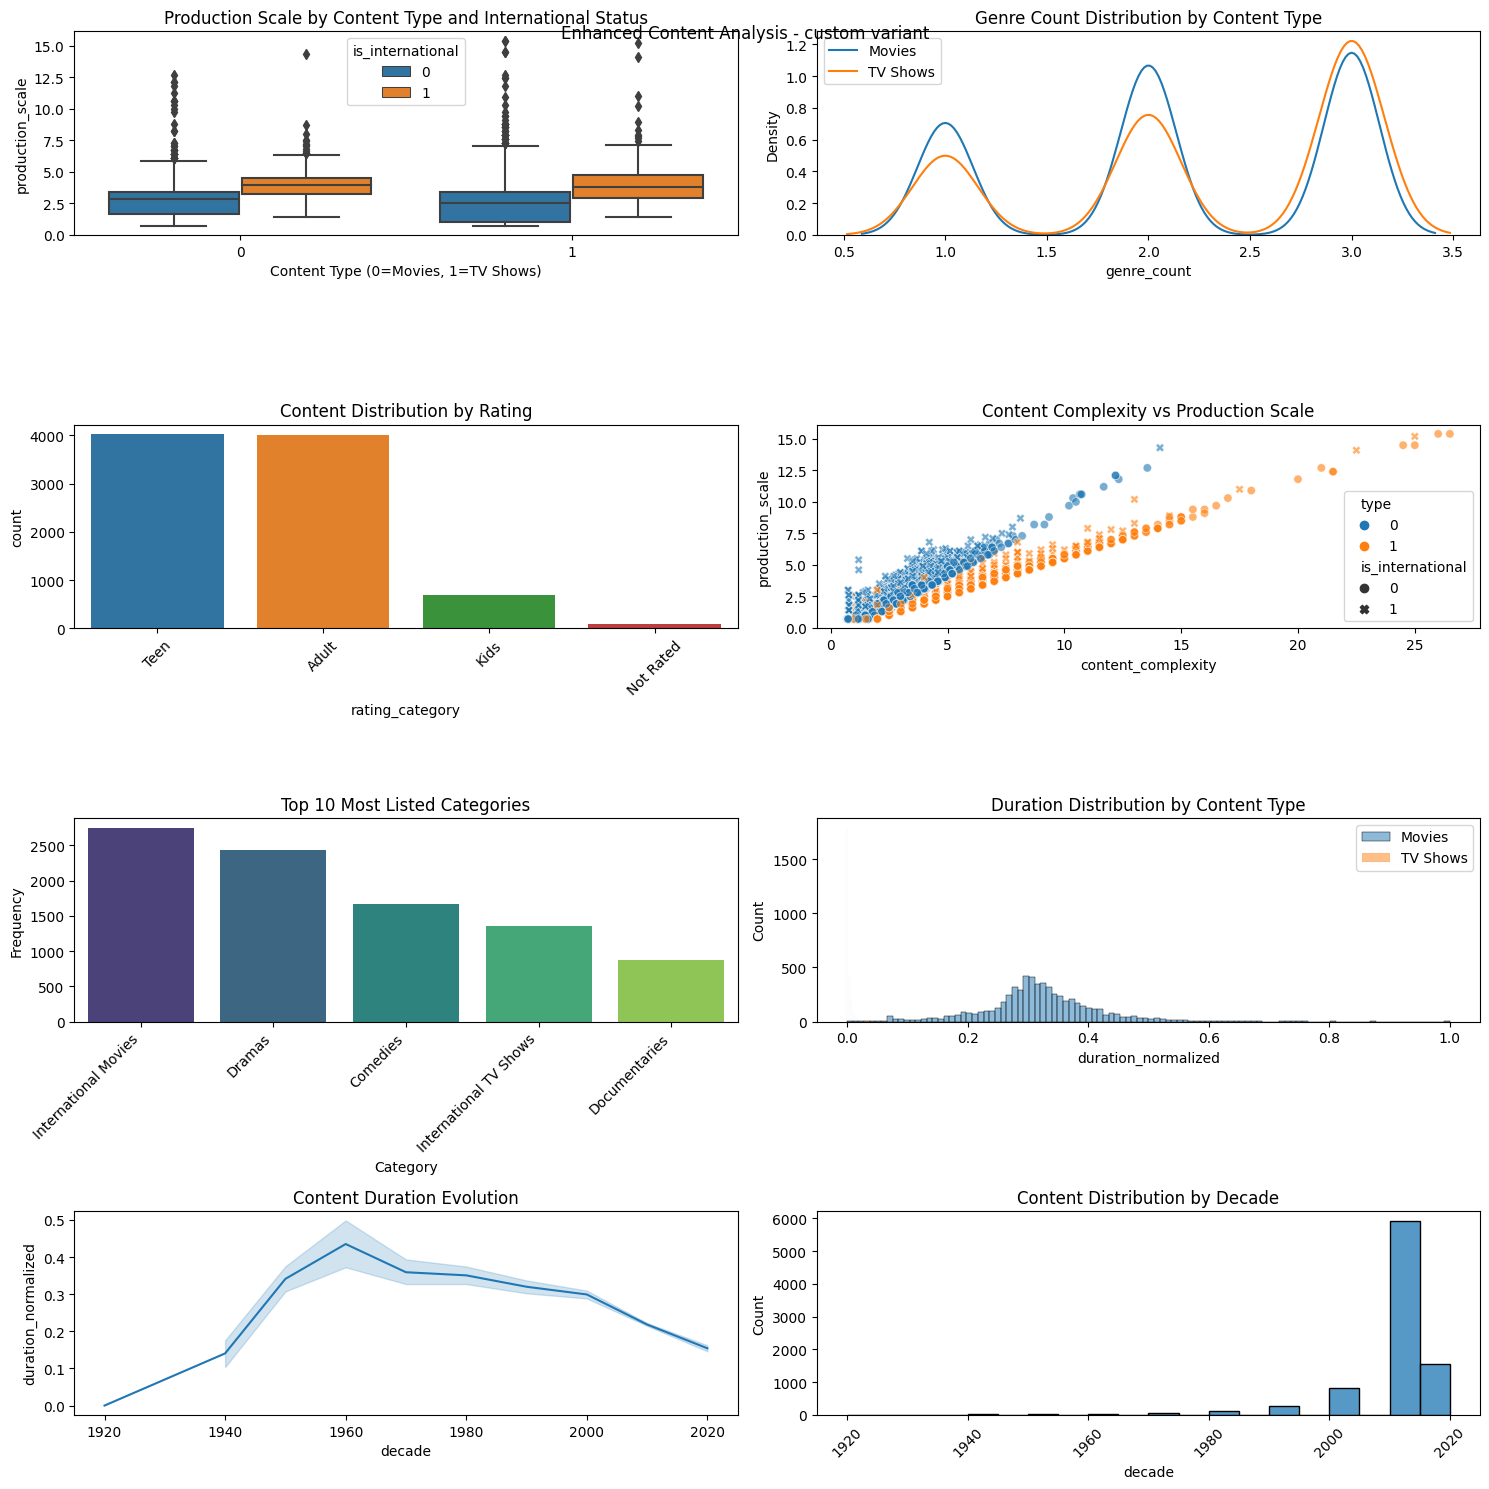


Summary Statistics by Content Type:

Movies:
       production_scale  content_complexity  genre_count  production_countries
count           6131.00             6131.00      6131.00               6131.00
mean               2.76                3.16         2.15                  1.28
std                1.34                1.37         0.78                  0.73
min                0.70                0.70         1.00                  1.00
25%                1.90                2.38         2.00                  1.00
50%                2.80                3.43         2.00                  1.00
75%                3.40                4.00         3.00                  1.00
max               14.30               14.09         3.00                 12.00

TV Shows:
       production_scale  content_complexity  genre_count  production_countries
count           2676.00             2676.00      2676.00               2676.00
mean               2.72                4.88         2.29                  

In [7]:
# New Operations Implementation
def enhance_features(df):
    """Enhanced feature engineering with new operations"""
    
    # 1. Separate analysis for Movies and TV Shows
    movies_mask = df['type'] == 0  # Assuming 0 is movies after encoding
    
    # 2. Production Scale Score
    df['production_scale'] = (
        df['production_countries'] * 0.4 +
        df['cast_size'] * 0.3 +
        df['is_international'].astype(int) * 0.3
    )
    
    # 3. Content Complexity Score - Separate for Movies and TV Shows
    df.loc[movies_mask, 'content_complexity'] = (
        df.loc[movies_mask, 'genre_count'] * 0.4 +
        df.loc[movies_mask, 'cast_size'] * 0.3 +
        df.loc[movies_mask, 'duration_normalized'] * 0.3
    )
    
    df.loc[~movies_mask, 'content_complexity'] = (
        df.loc[~movies_mask, 'genre_count'] * 0.5 +
        df.loc[~movies_mask, 'cast_size'] * 0.5
    )
    
    return df

def create_improved_visualizations(df):
    """Create separate visualizations for movies and TV shows"""
    movies_mask = df['type'] == 0
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 15))
    
    # 1. Production Scale Analysis
    plt.subplot(4, 2, 1)
    sns.boxplot(data=df, x='type', y='production_scale', hue='is_international')
    plt.title('Production Scale by Content Type and International Status')
    plt.xlabel('Content Type (0=Movies, 1=TV Shows)')
    
    # 2. Genre Analysis - Separate by Type
    plt.subplot(4, 2, 2)
    for content_type, mask in [('Movies', movies_mask), ('TV Shows', ~movies_mask)]:
        sns.kdeplot(data=df[mask], x='genre_count', label=content_type)
    plt.legend()
    plt.title('Genre Count Distribution by Content Type')
    
    # 3. Rating Distribution with Production Countries
    plt.subplot(4, 2, 3)
    sns.countplot(data=df, x='rating_category')
    plt.title('Content Distribution by Rating')
    plt.xticks(rotation=45)
    
    # 4. Content Complexity
    plt.subplot(4, 2, 4)
    sns.scatterplot(data=df, x='content_complexity', y='production_scale', 
                    hue='type', style='is_international', alpha=0.6)
    plt.title('Content Complexity vs Production Scale')
    
    # 5. Top Genres Distribution
    categories = df['listed_in'].str.split(',').explode().str.strip()  
    top_10_categories = categories.value_counts().head(5)
    
    plt.subplot(4, 2, 5)
    sns.barplot(x=top_10_categories.index, y=top_10_categories.values, palette='viridis')
    
    plt.title('Top 10 Most Listed Categories')
    plt.xlabel('Category')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
        
    # 6. Duration Analysis by Type
    plt.subplot(4, 2, 6)
    for content_type, mask in [('Movies', movies_mask), ('TV Shows', ~movies_mask)]:
        sns.histplot(data=df[mask], x='duration_normalized', 
                    label=content_type, alpha=0.5)
    plt.legend()
    plt.title('Duration Distribution by Content Type')
    
    # 7. Content Evolution Over Time
    plt.subplot(4, 2, 7)
    sns.lineplot(data=df, x='decade', y='duration_normalized')
    plt.title('Content Duration Evolution')
     
    # 8. Temporal Distribution
    plt.subplot(4, 2, 8)
    sns.histplot(data=df, x='decade', bins=20)
    plt.title('Content Distribution by Decade')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    return fig

# Apply new operations and create visualizations
for name, dataset in processed_variants.items():
    print(f"\nProcessing {name} variant:")
    
    # Apply new operations
    dataset = enhance_features(dataset)
    processed_variants[name] = dataset
    
    # Create and display new visualizations
    fig = create_improved_visualizations(dataset)
    plt.suptitle(f'Enhanced Content Analysis - {name} variant')
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics by Content Type:")
    for content_type in [0, 1]:  # 0 for movies, 1 for TV shows
        mask = dataset['type'] == content_type
        type_name = 'Movies' if content_type == 0 else 'TV Shows'
        print(f"\n{type_name}:")
        print(dataset[mask][['production_scale', 'content_complexity', 
                           'genre_count', 'production_countries']].describe().round(2))

# 4. Data modeling:

dropped - Silhouette Score: 0.5403
mean_mode - Silhouette Score: 0.5058
custom - Silhouette Score: 0.4603


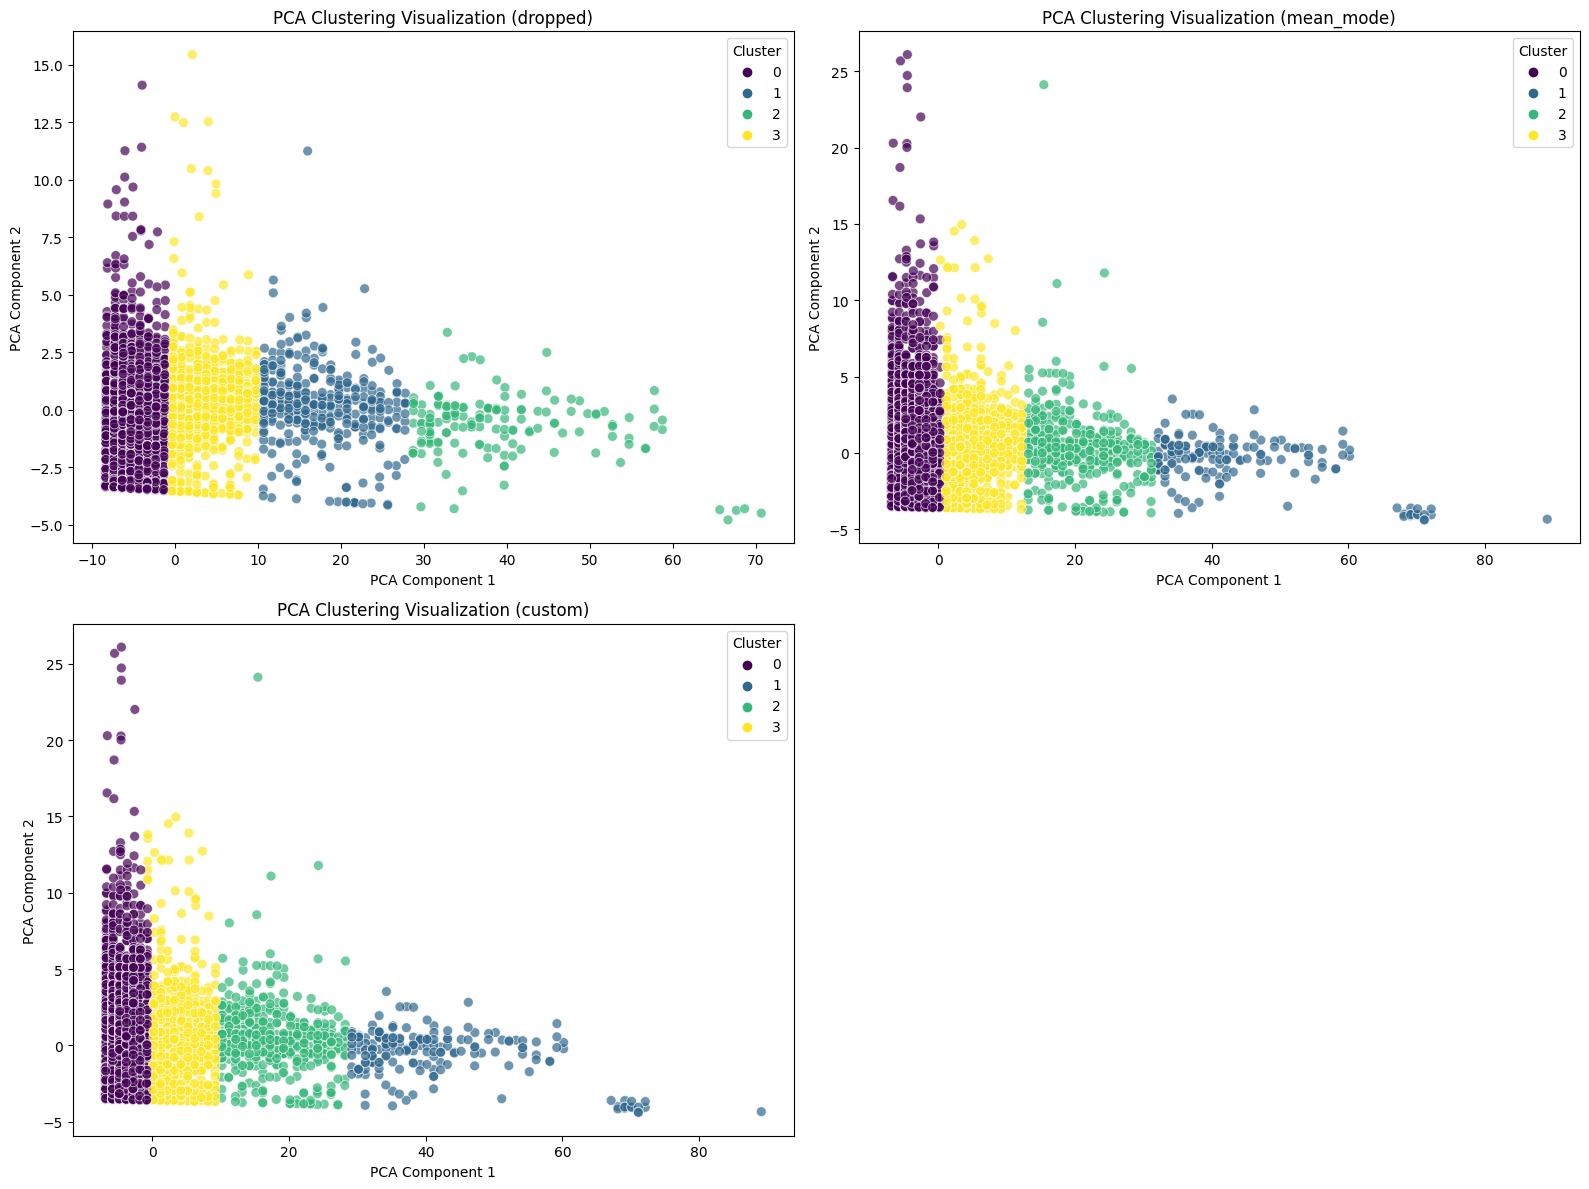

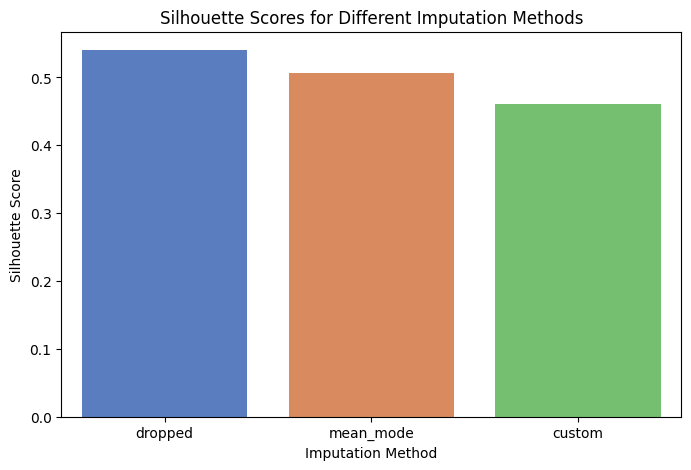

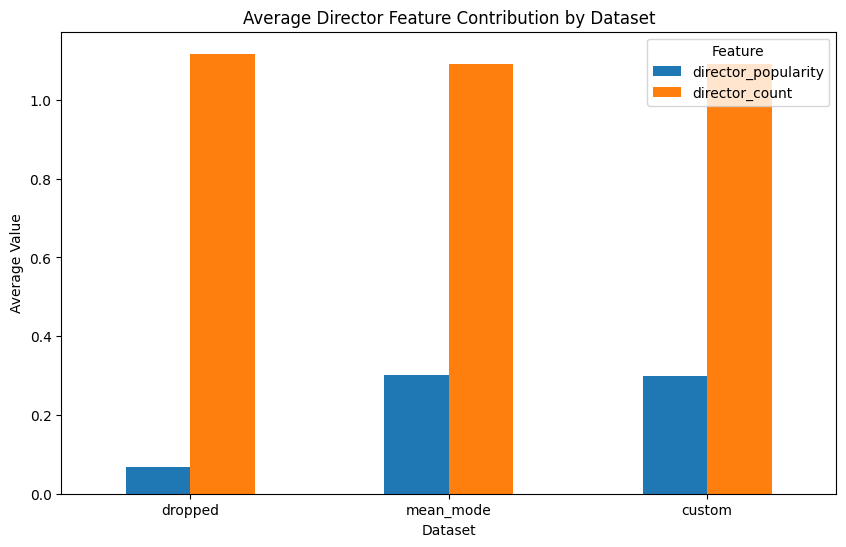

In [8]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

def perform_clustering_and_evaluate(datasets, features, n_clusters=4):
    cluster_results = {}
    silhouette_scores = {}

    for name, dataset in datasets.items():
        # Perform clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(dataset[features])
        cluster_results[name] = labels

        # Calculate silhouette score
        silhouette_scores[name] = silhouette_score(dataset[features], labels)

        print(f"{name} - Silhouette Score: {silhouette_scores[name]:.4f}")

    return cluster_results, silhouette_scores

def visualize_clustering_results(cluster_results, datasets, features):
    """
    Generate visualizations for clustering results across different imputation methods.

    Args:
        cluster_results (dict): Dictionary with clustering labels for each dataset variant.
        datasets (dict): Dictionary with processed datasets.
        features (list): List of features used for clustering.
    """
    pca = PCA(n_components=2)
    silhouette_scores = {}

    # PCA Visualization
    plt.figure(figsize=(16, 12))
    for i, (name, dataset) in enumerate(datasets.items()):
        X = dataset[features]
        pca_result = pca.fit_transform(X)
        labels = cluster_results[name]

        # PCA Scatter Plot
        plt.subplot(2, 2, i + 1)
        sns.scatterplot(
            x=pca_result[:, 0], y=pca_result[:, 1], 
            hue=labels, palette='viridis', s=50, alpha=0.7
        )
        plt.title(f'PCA Clustering Visualization ({name})')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.legend(title='Cluster', loc='upper right')

    plt.tight_layout()
    plt.show()

    # Silhouette Scores Visualization
    silhouette_scores = {
        name: silhouette_score(datasets[name][features], cluster_results[name]) 
        for name in datasets.keys()
    }
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(silhouette_scores.keys()), y=list(silhouette_scores.values()), palette="muted")
    plt.title("Silhouette Scores for Different Imputation Methods")
    plt.ylabel("Silhouette Score")
    plt.xlabel("Imputation Method")
    plt.show()

    # Feature Contribution Visualization (example for director features)
    director_features = ['director_popularity', 'director_count']
    director_importance = {name: datasets[name][director_features].mean() for name in datasets.keys()}
    director_importance_df = pd.DataFrame(director_importance).T
    director_importance_df.plot(kind='bar', figsize=(10, 6))
    plt.title("Average Director Feature Contribution by Dataset")
    plt.ylabel("Average Value")
    plt.xlabel("Dataset")
    plt.xticks(rotation=0)
    plt.legend(title="Feature")
    plt.show()

features_for_clustering = ['content_age',
                           'cast_diversity',
                           'content_complexity',
                           'production_scale',
                           'director_popularity', 
                           'director_count']
cluster_results, silhouette_scores = perform_clustering_and_evaluate(processed_variants, features_for_clustering, n_clusters=4)
visualize_clustering_results(cluster_results, processed_variants, features_for_clustering)



# 5. Clustering Analysis Report

## **Textual Description of Work**

### **Problem Overview**
The goal of this analysis was to cluster a dataset of multimedia content (e.g., movies, shows) into meaningful groups. Various imputation methods (dropping, mean-mode, custom) were applied to handle missing data, with a focus on understanding their impact on clustering quality.

### **Approach**

#### **Feature Engineering**
- Temporal features like `content_age` and `decade`.
- Genre-based features using TF-IDF vectorization.
- Cast-related metrics such as `cast_diversity` and `cast_size`.
- A new **director** feature was engineered:
  - **Director Popularity**: Frequency of director appearances.
  - **Director Diversity**: Number of directors listed per content.
- Features were scaled and normalized for clustering.

#### **Data Variants**
Three imputation methods were tested:
1. **Dropped**: Rows with missing values were removed.
2. **Mean-Mode**: Missing values were replaced with the mean (numerical) or mode (categorical).
3. **Custom**: Domain-specific rules for imputation.

#### **Clustering**
- K-Means clustering was applied to all data variants.
- Cluster quality was assessed using silhouette scores and visualizations.

#### **Key Finding**
The **dropped dataset** produced the most distinct and meaningful clusters, highlighting the significant role of the **director** feature when complete.

---

## **Visualizations**

### 1. **Cluster Visualization with PCA**
A PCA plot showed distinct separation of clusters for the dropped dataset, compared to less clear separation in the mean-mode and custom datasets.

### 2. **Silhouette Scores**
A bar chart illustrated higher silhouette scores for the dropped dataset, confirming better-defined clusters compared to other methods.

### 3. **Feature Contribution**
A bar chart compared the contribution of the **director**-related features (popularity, diversity) across the datasets, emphasizing their significance in the dropped dataset.

---

## **Key Findings**

### 1. **Clustering Quality**
- The dropped dataset outperformed others, likely due to the removal of rows with missing director information, which might have introduced noise in the mean-mode and custom imputation datasets.

### 2. **Director Feature Significance**
- The **director** feature, especially its engineered components (popularity, diversity), played a pivotal role in improving clustering quality.

### 3. **Impact of Missing Data**
- The similarity in clustering results between mean-mode and custom imputation suggests that missing values were not critical for most features.
- However, the presence of missing **director** values diluted the impact of this key feature in those datasets.

---

## **Decisions Based on Facts**

### 1. **Data Preprocessing**
- Dropping rows with missing values is a valid strategy when the percentage of missing data is low and critical features (like `director`) are incomplete.

### 2. **Feature Engineering**
- Including a well-crafted **director** feature was crucial for clustering. This highlights the importance of domain-specific feature engineering.

### 3. **Clustering Robustness**
- K-Means clustering was robust against minor differences in imputation methods for most features. However, critical features like `director` significantly impacted clustering when complete.

---

## **Conclusion**

1. The dropped dataset yielded the best clustering results due to the removal of incomplete and potentially noisy rows.
2. The **director** feature was pivotal in improving clustering quality, and its absence (due to missing values) impacted the mean-mode and custom datasets.
3. Future workflows should prioritize:
   - Dropping rows with missing critical values when feasible.
   - Exploring advanced imputation techniques to better estimate missing values for critical features.

